In [1]:
import json
import datetime
import re

import logging
import math
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from queryrunner_client import Client
qclient = Client(user_email='jiawei.wang@uber.com')
USER_EMAIL = 'jiawei.wang@uber.com'
CONSUMER_NAME = 'intelligentdispatch'

import os
import warnings
warnings.filterwarnings('ignore')
import multiprocessing
from joblib import Parallel, delayed
#num_cores = multiprocessing.cpu_count()
n_cores = 4
from dataclasses import dataclass
import itertools
from typing import *
import numpy as np
import pandas as pd
from queryrunner_client import Client as QRClient
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

In [2]:
import mdstk
from mdstk.data_fetcher.data_fetcher import DataFetcher
from mdstk.data_fetcher.cached_data_fetcher import CachedDataFetcher


In [3]:
class MyDataFetcher(DataFetcher):
    def query_many_presto(self, *args, **kwargs):
        return super().query_many_presto(*args, **kwargs)

In [4]:
QUERY = """
with polysolve as (
select 
p.msg.city_id,
p.msg.scan_uuid,
mfs.msg.scantype,
p.msg.cluster_index,
p.msg.scan_timestamp,
p.msg.job_uuid,
p.msg.plangen_uuid,
p.msg.is_overwritten,
p.msg.supply_uuid,
p.msg.adjusted_eta_production,
p.msg.adjusted_eta_shadow,
p.msg.selected_supply_shadow,
m1.msg.solo_cancel_model_driver_accept_prob * m1.msg.solo_cancel_model_rider_accept_prob as cr_primary,
m2.msg.solo_cancel_model_driver_accept_prob * m2.msg.solo_cancel_model_rider_accept_prob as cr_secondary,
fare.est_rider_quoted_final_fare as fare,
count(*)
from rawdata_user.kafka_hp_multileg_poly_solve_logs_nodedup p
join rawdata.kafka_hp_multileg_mgv_log_nodedup m1 
on p.msg.job_uuid = m1.msg.job_uuid
and p.msg.plangen_uuid = m1.msg.ct_request_uuid
and p.msg.supply_uuid = m1.msg.supply_uuid
and m1.datestr between '2022-08-01' and '2022-08-07'
and m1.msg.city_id = {city_id}
join rawdata.kafka_hp_multileg_mgv_log_nodedup m2
on p.msg.job_uuid = m2.msg.job_uuid
and p.msg.plangen_uuid = m2.msg.ct_request_uuid
and p.msg.selected_supply_shadow = m2.msg.supply_uuid
and m2.datestr between '2022-08-01' and '2022-08-07'
and m2.msg.city_id = {city_id}
join dwh.fact_trip_fare fare 
on p.msg.job_uuid = fare.trip_uuid
and fare.datestr between '2022-08-01' and '2022-08-07'
and fare.city_id = {city_id}
join rawdata_user.kafka_hp_multileg_matching_fast_slow_logs_nodedup mfs 
on p.msg.scan_uuid = mfs.msg.ctrequestuuid
and mfs.datestr between '2022-08-01' and '2022-08-07'
and mfs.msg.cityid = {city_id}
where  p.datestr between '2022-08-01' and '2022-08-07'
and p.msg.city_id = {city_id}
--and (msg.supply_uuid is not null or msg.selected_supply_shadow is not null)
and (p.msg.supply_uuid is not null and p.msg.selected_supply_shadow is not null)
and (p.msg.is_overwritten = true or p.msg.supply_uuid is not null)
and p.msg.is_selected_second_stage is null
and p.msg.adjusted_eta_production <= 1500
and substr(p.msg.cluster_index, 1, 3) = 'dis'
group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15
),
scan_overwrite as (
select 
city_id,
scan_uuid,
scantype,
cluster_index,
is_overwritten,
count(job_uuid) as cluster_size,
sum(adjusted_eta_production) as total_primary_eta,
sum(adjusted_eta_shadow) as total_secondary_eta,
sum(fare * cr_primary) as total_gb_primary,
sum(fare * cr_secondary) as total_gb_secondary,
count(job_uuid) - sum(case when supply_uuid = selected_supply_shadow then 1 end) as overwrite_jobs
from polysolve 
group by 1,2,3,4,5
)
select 
*
from scan_overwrite
"""

In [5]:
class MyDataFetcher(DataFetcher):
    def query_many_presto(self, *args, **kwargs):
        return super().query_many_presto(*args, **kwargs)

In [6]:
@dataclass
class RTCQuery:
    city_id: int
    
    def __post_init__(self):
        self.name = f'RTC_city{self.city_id}_MFS'
        self.qry = QUERY.format(city_id=self.city_id)

INFO:jaeger_tracing:Tracing sampler started with sampling refresh interval 60 sec


In [7]:
queries = [
    RTCQuery(city_id=city_id)
    for city_id in [19,1542,140,335,41,187,136,133,13,20,21,26,1,198,10]
]

cache_qry_map = {
    q.name: q.qry 
    for q in queries
}

cdf = CachedDataFetcher(
    data_fetcher=MyDataFetcher(
        user_email=USER_EMAIL,
        consumer_name=CONSUMER_NAME,
    ),
    cache_qry_map=cache_qry_map,
    datacenter='dca1',
    datasource='presto-secure',
)
cdf.fetch(bust_cache=False)

08/23/2022 04:04:25 PM  You're using Queryrunner V2! 
08/23/2022 04:04:25 PM  You're using Queryrunner V2! 


Loaded 0/15 dataframes from cache!


08/23/2022 04:04:25 PM  You're using Queryrunner V2! 
08/23/2022 04:04:25 PM  You're using Queryrunner V2! 
08/23/2022 04:04:25 PM  You're using Queryrunner V2! 
08/23/2022 04:04:26 PM  You're using Queryrunner V2! 
08/23/2022 04:04:26 PM  You're using Queryrunner V2! 
08/23/2022 04:04:26 PM  You're using Queryrunner V2! 
08/23/2022 04:04:26 PM  You're using Queryrunner V2! 
08/23/2022 04:04:26 PM  You're using Queryrunner V2! 
08/23/2022 04:04:26 PM  You're using Queryrunner V2! 
08/23/2022 04:04:26 PM  You're using Queryrunner V2! 
08/23/2022 04:04:26 PM  You're using Queryrunner V2! 
08/23/2022 04:04:27 PM  You're using Queryrunner V2! 
08/23/2022 04:04:27 PM  You're using Queryrunner V2! 


In [13]:
df = pd.concat(cdf.dfs.values(), axis=0, ignore_index=True)
df = df.dropna()
df = df[(df['cluster_size']>1)&(df['cluster_size']<=120)]
df['overwrite_rate'] = df['overwrite_jobs']/df['cluster_size']
df['avg_eta_increase'] = (df['total_secondary_eta'] - df['total_primary_eta']) / df['cluster_size']
df['avg_gb_increase'] = (df['total_gb_secondary'] - df['total_gb_primary']) / df['cluster_size']
df['cluster size'] = df['cluster_size']//5 * 5



In [17]:
from collections import defaultdict
clusters_nom_fast = defaultdict(lambda: 0)
clusters_denom_fast = defaultdict(lambda: 0)
clusters_nom_slow = defaultdict(lambda: 0)
clusters_denom_slow = defaultdict(lambda: 0)
for index, row in df.iterrows():
    if row['scantype'] == 'fast':
        if row['is_overwritten']:
            clusters_nom_fast[row['cluster_size']] += 1
        clusters_denom_fast[row['cluster_size']] += 1
    elif row['scantype'] == 'slow':
        if row['is_overwritten']:
            clusters_nom_slow[row['cluster_size']] += 1
        clusters_denom_slow[row['cluster_size']] += 1

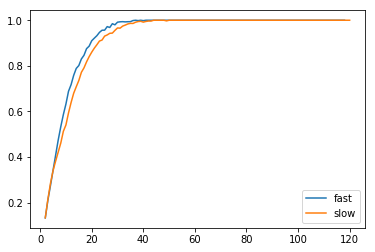

In [18]:
scan_level_rate_fast = []
x_fast = []
for key in sorted(clusters_denom_fast.keys()):
    scan_level_rate_fast.append(clusters_nom_fast[key] / clusters_denom_fast[key])
    x_fast.append(key)
scan_level_rate_slow = []
x_slow = []
for key in sorted(clusters_denom_slow.keys()):
    scan_level_rate_slow.append(clusters_nom_slow[key] / clusters_denom_slow[key])
    x_slow.append(key)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# fig, ax = plt.subplots()

# sns.lineplot(ax = ax,
#              data = df,
#              x = 'cluster size',
#              y = 'overwrite_rate',
#              hue = 'scantype'
#             )
plt.plot(x_fast, scan_level_rate_fast, label='fast')
plt.plot(x_slow, scan_level_rate_slow, label='slow')
plt.legend()

plt.show()

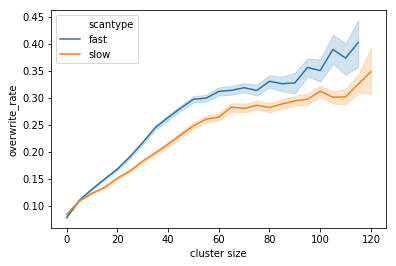

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
fig, ax = plt.subplots()

sns.lineplot(ax = ax,
             data = df,
             x = 'cluster size',
             y = 'overwrite_rate',
             hue = 'scantype'
            )

plt.show()

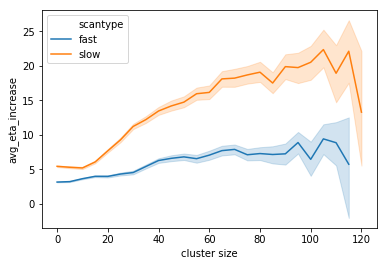

In [19]:
fig, ax = plt.subplots()

sns.lineplot(ax = ax,
             data = df,
             x = 'cluster size',
             y = 'avg_eta_increase',
             hue = 'scantype'
            )

plt.show()

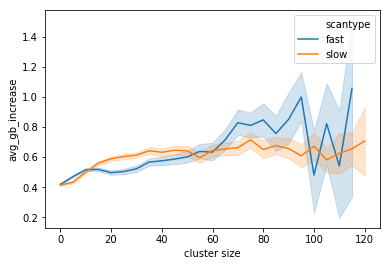

In [21]:
fig, ax = plt.subplots()

sns.lineplot(ax = ax,
             data = df,
             x = 'cluster size',
             y = 'avg_gb_increase',
             hue = 'scantype'
            )

plt.show()

In [22]:
plot_df = df.groupby(['scan_uuid','scantype'])['cluster_index'].count()


In [23]:
def ttt(l,a):
    r = 0
    for x in l:
        if x == a:
            r+=1
    return r * 1.0/len(l)

In [24]:
fast_scans = df[df.scantype == 'fast']
slow_scans = df[df.scantype == 'slow']

In [25]:
new_df_fast = pd.DataFrame()
new_df_fast['x'] = [i for i in range(2,21)]
new_df_fast['pct'] = [ttt(fast_scans['cluster_size'], i) for i in range(2,21) ]
new_df_fast['scan'] = ['fast']*new_df_fast.shape[0]

In [26]:
new_df_slow = pd.DataFrame()
new_df_slow['x'] = [i for i in range(2,21)]
new_df_slow['pct'] = [ttt(slow_scans['cluster_size'], i) for i in range(2,21) ]
new_df_slow['scan'] = ['slow']*new_df_fast.shape[0]

In [27]:
plot_df = new_df_fast.append(new_df_slow)


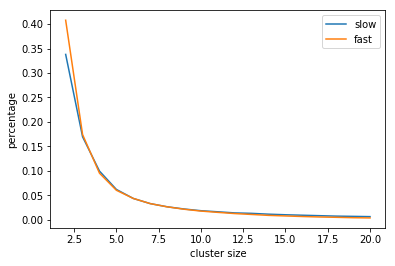

In [28]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

for name in ['slow','fast']:
    ax.plot(plot_df[plot_df.scan==name].x,plot_df[plot_df.scan==name].pct,label=name)

ax.set_xlabel("cluster size")
ax.set_ylabel("percentage")
ax.legend(loc='best')